# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier,DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.types import DateType
from pyspark.sql import functions as F
from pyspark.sql.functions import from_unixtime
import numpy as np

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark=SparkSession\
.builder\
.appName("The Capstone Project")\
.getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path="mini_sparkify_event_data.json"
user_log=spark.read.json(path)

In [4]:
#Looking at the first row of the dataset
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
#Let us check the schema of this dataset
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#Let us see the distinct userIds from the data
user_log.select("userId").dropDuplicates().sort("userId").show()

#Let us see all the distinct session Ids from the data
user_log.select("sessionId").dropDuplicates().sort("sessionId").show()


+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [7]:
#Let us see the number of users in the dataset
print(user_log.count())

#Let us try deleting the rows with any missing value
user_log_valid=user_log.dropna(how="any",subset=["userId","sessionId"])
user_log_valid.count()

286500


286500

Now,since we can see that there are no missing values in both the userId and the sessionId column but there are " " values in the userId column,so we will drop the rows with these values.


In [8]:
user_log_valid=user_log_valid.filter(user_log_valid["userId"]!="")
user_log_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
#Let us try to convert the time to date and hours
user_log_valid=user_log_valid.withColumn('actual_date', from_unixtime(F.col('ts')/1000).alias('date'))
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log_valid=user_log_valid.withColumn('hour',get_hour(user_log.ts))

In [10]:
user_log_valid.head(10)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', actual_date='2018-10-01 00:01:57', hour='0'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', actual_date='2018-10-01 00:03:00', hour='0'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', g

In [11]:
#Let us see the schema of this dataframe now
user_log_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- actual_date: string (nullable = true)
 |-- hour: string (nullable = true)



In [12]:
#Let us try to evaluate the page column to see what distinct values it contains
user_log_valid.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



## Churn: 
We are defining a customer as churned when he visits the page "Cancellation Confirmation".Using this definition,we will add a column named Churn in our datset

In [13]:
user_churn=user_log_valid.filter(user_log_valid.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churned_users=[(row['userId']) for row in user_churn.collect()]
df_churn=user_log_valid.withColumn("Churn",(user_log_valid.userId.isin(churned_users)))

In [14]:
#Let us see the first row of this dataframe
df_churn.head(40)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', actual_date='2018-10-01 00:01:57', hour='0', Churn=False),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', actual_date='2018-10-01 00:03:00', hour='0', Churn=False),
 Row(artist='Adam Lambert', auth='Logged

In [15]:
#Let us see the number of songs being played hour wise
song_in_hour= df_churn.filter(df_churn.page == "NextSong").groupby(df_churn.hour).count().orderBy(df_churn.hour.cast("float"))
song_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [16]:
#Let us try plotting a scatterplot to see the number of songs played every hour
song_in_hour_pd=song_in_hour.toPandas()
song_in_hour_pd.hour=pd.to_numeric(song_in_hour_pd.hour)

In [ ]:
#The kernel keeps dying when I plot this plot.So,I have not executed this cell again
plt.scatter(song_in_hour_pd["hour"],song_in_hour["count"])
plt.xlim(-1,24)
plt.ylim(0,1.2*max(song_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs Played")

In [17]:
#Let us create the group of churned as well as unchurned users
churn_vs_unchurn= df_churn.dropDuplicates(['userId']).groupby("Churn").count()
churn_vs_unchurn.show()


+-----+-----+
|Churn|count|
+-----+-----+
| true|   52|
|false|  173|
+-----+-----+



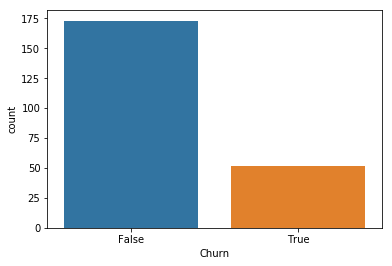

In [18]:
#Plotting the count of churned vs non churned users
import seaborn as sns
churn_vs_unchurn_pd=churn_vs_unchurn.toPandas()
sns.barplot(x='Churn', y='count', data=churn_vs_unchurn_pd)

So,from the above plot we can see that out of the total 225 unique users,only 52 have churned whereas 173 have not

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
| true|     F|   20|
|false|     M|   89|
| true|     M|   32|
|false|     F|   84|
+-----+------+-----+



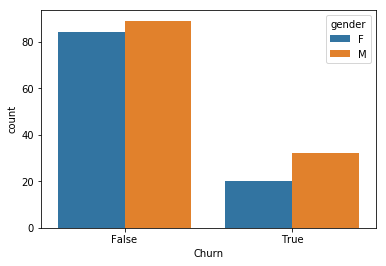

In [19]:
#Let us see the gender wise seggregation of users
churn_vs_unchurn_gender=df_churn.dropDuplicates(["userId","gender"]).groupby(["Churn","gender"]).count()
churn_vs_unchurn_gender.show()
churn_vs_unchurn_gender_pd=churn_vs_unchurn_gender.toPandas()
sns.barplot(x="Churn",y="count",hue="gender",data=churn_vs_unchurn_gender_pd)


Out of the 52 churned users,20 are female and 32 are male.So,there is not a lot of difference between these two genders as far as the churned users are concerned

In [86]:
#Let us see the pages that were visited by the churned and the unchurned-users
churn_count = df_churn.filter(df_churn.Churn==1).count()
no_churn_count = df_churn.filter(df_churn.Churn==0).count()

df_temp1 = df_churn.filter(df_churn.Churn==1).filter(df_churn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("Churn Freq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_churn.filter(df_churn.Churn==0).filter(df_churn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("Nonchurn Freq", df_temp2["count"]/(no_churn_count/100)).sort("page")


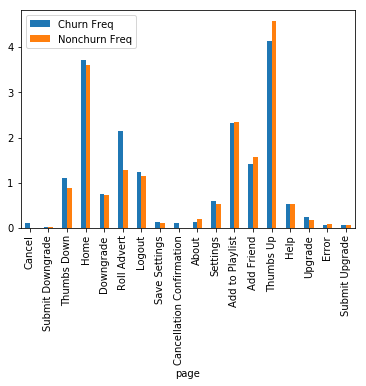

In [87]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")

From the above visual,we can see that the churned users visited page such as Roll Advert,Thumbs Down and Downgrade pages more than the unchurned users

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



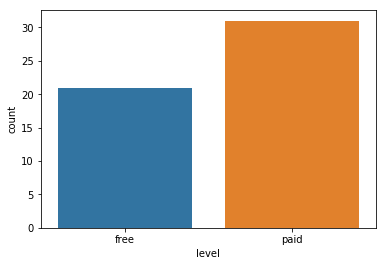

In [25]:
#Let us see how many paid users churned vs free users
paid_vs_free_churned=df_churn.filter(df_churn.page=="Cancellation Confirmation").groupby(["level"]).count()
paid_vs_free_churned.show()
paid_vs_free_churned_pd=paid_vs_free_churned.toPandas()
sns.barplot(x="level",y="count",data=paid_vs_free_churned_pd)

From the above visual it is clear that more paid users churned when compared to free users althought the difference between both these groups is not large.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Extracting features from the datset

### 1 Songs played per user

In [26]:
#Let us get the count of the songs played by each user
songs_played_user=df_churn\
                  .filter(df_churn.song!="null")\
                  .select("userId","song")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","songs_played")
songs_played_user.show(50)

+------+------------+
|userId|songs_played|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
|    51|        2111|
|   124|        4079|
|     7|         150|
|    54|        2841|
|    15|        1914|
|   155|         820|
|   132|        1928|
|   154|          84|
|100014|         257|
|   101|        1797|
|    11|         647|
|   138|        2070|
|300017|        3632|
|    29|        3028|
|    69|        1125|
|100021|         230|
|    42|        3573|
|   112|         215|
|    87|         767|
|    73|         377|
|    64|          46|
|200010|         237|
|     3|         214|
|    30|        1417|
|   113|        1585|
|    34|          53|
|   133|          32|
|    59|         724|
|   146|         650|
|   139|         377|
|     8|         251|
|    28|        1457|
|    22|          28|
|300018|        1640|
|300012|         642|
|100022|         681|
|    85|        3616|
|    52|        1086|
|    35|        1610|
|    16|  

### 2 Errors per user

In [27]:
Errors_per_user=df_churn\
                  .filter(df_churn.page=="Error")\
                  .select("userId","page")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","Errors")
Errors_per_user.show(10)

+------+------+
|userId|Errors|
+------+------+
|   124|     6|
|    51|     1|
|     7|     1|
|    15|     2|
|    54|     1|
|   155|     3|
|   132|     3|
|   101|     3|
|    11|     1|
|   138|     1|
+------+------+
only showing top 10 rows



### 3 Friends added by each user

In [28]:
Friends_per_user=df_churn\
                  .filter(df_churn.page=="Add Friend")\
                  .select("userId","page")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","Friends_Added")
Friends_per_user.show(20)

+------+-------------+
|userId|Friends_Added|
+------+-------------+
|100010|            4|
|200002|            4|
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   155|           11|
|   132|           41|
|   154|            3|
|100014|            6|
|   101|           29|
|    11|            6|
|   138|           41|
|300017|           63|
|    29|           47|
|    69|           12|
|100021|            7|
|    42|           52|
|   112|            7|
+------+-------------+
only showing top 20 rows



### 4 Songs added in Playlist

In [29]:
Songs_added_per_user=df_churn\
                  .filter(df_churn.page=="Add to Playlist")\
                  .select("userId","page")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","Songs_Added")
Songs_added_per_user.show(20)

+------+-----------+
|userId|Songs_Added|
+------+-----------+
|100010|          7|
|200002|          8|
|    51|         52|
|   124|        118|
|     7|          5|
|    15|         59|
|    54|         72|
|   155|         24|
|   132|         38|
|   154|          1|
|100014|          7|
|   101|         61|
|    11|         20|
|   138|         67|
|300017|        113|
|    29|         89|
|    69|         33|
|100021|          7|
|    42|        104|
|   112|          7|
+------+-----------+
only showing top 20 rows



### 5 Number of thumbs up

In [30]:
Up_per_user=df_churn\
                  .filter(df_churn.page=="Thumbs Up")\
                  .select("userId","page")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","Up_per_user")
Up_per_user.show(20)

+------+-----------+
|userId|Up_per_user|
+------+-----------+
|100010|         17|
|200002|         21|
|    51|        100|
|   124|        171|
|     7|          7|
|    54|        163|
|    15|         81|
|   155|         58|
|   132|         96|
|   154|         11|
|100014|         17|
|   101|         86|
|    11|         40|
|   138|         95|
|300017|        303|
|    29|        154|
|    69|         72|
|100021|         11|
|    42|        166|
|   112|          9|
+------+-----------+
only showing top 20 rows



### 6 Number of thumbs down

In [31]:
Down_per_user=df_churn\
                  .filter(df_churn.page=="Thumbs Down")\
                  .select("userId","page")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","Down_per_user")
Down_per_user.show(20)

+------+-------------+
|userId|Down_per_user|
+------+-------------+
|100010|            5|
|200002|            6|
|    51|           21|
|   124|           41|
|     7|            1|
|    15|           14|
|    54|           29|
|   155|            3|
|   132|           17|
|100014|            3|
|   101|           16|
|    11|            9|
|   138|           24|
|300017|           28|
|    29|           22|
|    69|            9|
|100021|            5|
|    42|           25|
|   112|            3|
|    73|            7|
+------+-------------+
only showing top 20 rows



### 7 Number of average songs played by users across session

In [32]:
songs_per_session=df_churn\
                  .filter(df_churn.page=="NextSong")\
                  .groupby(['userId','sessionId'])\
                  .count()\
                  .groupby(['userId'])\
                  .agg({'count':'avg'})\
                  .withColumnRenamed('avg(count)','avg_songs_played')
songs_per_session.show(20)

+------+------------------+
|userId|  avg_songs_played|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



### 8 Total Listening time

In [88]:
listen_time=df_churn\
            .select('userId','length')\
            .groupby(['userId'])\
            .sum()\
            .withColumnRenamed('sum(length)','listening_time')

listen_time.show(10)

+------+------------------+
|userId|    listening_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
+------+------------------+
only showing top 10 rows



### 9 Time since registration

In [34]:
from pyspark.sql.functions import col
span=df_churn\
    .select('userId','ts','registration')\
    .withColumn('span',(df_churn.ts-df_churn.registration))\
    .groupby(['userId'])\
    .agg({'span':'max'})\
    .withColumnRenamed('max(span)','span')\
    .select('userId',(col('span')/1000/3600/24).alias('span'))\

span.show(10)
    

+------+------------------+
|userId|              span|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
+------+------------------+
only showing top 10 rows



### 10 Gender

In [35]:
gender=df_churn\
       .select('userId','gender')\
       .dropDuplicates()\
       .replace(['M','F'],['0','1'],'gender')\
       .select('userId',col('gender').cast('int'))

gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
+------+------+
only showing top 10 rows



In [36]:
# Let us try to have a column status that is 1 when the churn is True and 0 when the churn is False
status=udf(lambda x : 1 if x==True else 0 ,IntegerType())
df_churn=df_churn.withColumn('status',status('Churn'))
df_churn.show(50)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|        actual_date|hour|Churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|     0|1538352117000|Mozilla/5.0 (Wind...|    30|

In [37]:
label=df_churn.select('userId','status').dropDuplicates()
label=label.select('userId',label.status.cast("int"))
label.show(10)

+------+------+
|userId|status|
+------+------+
|    19|     0|
|100005|     1|
|200007|     0|
|300007|     1|
|    50|     0|
|200002|     0|
|    30|     0|
|     8|     0|
|100011|     1|
|100012|     1|
+------+------+
only showing top 10 rows



## Putting all the features dataframe together

In [38]:
feat_list=[]
feat_list.append(songs_played_user)
feat_list.append(Errors_per_user)
feat_list.append(Friends_per_user)
feat_list.append(Songs_added_per_user)
feat_list.append(Up_per_user)
feat_list.append(Down_per_user)
feat_list.append(songs_per_session)
feat_list.append(listen_time)
feat_list.append(span)
feat_list.append(gender)
feat_list.append(label)

In [39]:
#Get the final dataframe with which we will join all the features
df_final=df_churn.select("userId").dropDuplicates()
df_final.show(10)

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
+------+
only showing top 10 rows



### Now we have to write a function using which we can join all the features in the feature list to this dataframe

In [40]:
def create_final_df(df1,df2):
    df2=df2.withColumnRenamed("userId","userIdTemp")
    df=df1.join(df2,df1.userId==df2.userIdTemp,"left").drop("userIdTemp")
    df=df.fillna(0)
    return df

In [41]:
#Now let us use this function to create the final dataframe from all our users
for feature in feat_list:
    df_final=create_final_df(df_final,feature)

In [42]:
df_final.show(10)

+------+------------+------+-------------+-----------+-----------+-------------+------------------+------------------+------------------+------+------+
|userId|songs_played|Errors|Friends_Added|Songs_Added|Up_per_user|Down_per_user|  avg_songs_played|    listening_time|              span|gender|status|
+------+------------+------+-------------+-----------+-----------+-------------+------------------+------------------+------------------+------+------+
|100010|         275|     0|            4|          7|         17|            5|39.285714285714285| 66940.89735000003|  55.6436574074074|     1|     0|
|200002|         387|     0|            4|          8|         21|            6|              64.5| 94008.87593999993| 70.07462962962963|     0|     0|
|   125|           8|     0|            0|          0|          0|            0|               8.0|2089.1131000000005| 71.31688657407408|     0|     1|
|   124|        4079|     6|           74|        118|        171|           41|145.6785

In [43]:
df_final.groupby("status").count().show()

+------+-----+
|status|count|
+------+-----+
|     1|   52|
|     0|  173|
+------+-----+



Since,now we have a dataframe that has all the features and the target column "Status",let us begin the modelling

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

First,let us create a vector of our features

In [44]:
cols=["songs_played","Errors","Friends_Added","Songs_Added","Up_per_user","Down_per_user",\
      "avg_songs_played","listening_time","span","gender"]
assembler=VectorAssembler(inputCols=cols,outputCol="NumFeatures")
df_final=assembler.transform(df_final)

Now,let us standardise all the features so that none of the features have undue advantage over the other in predicting the customer churn

In [45]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_final)

# Normalize each feature to have unit standard deviation.
df_final = scalerModel.transform(df_final)
df_final.show(10)



+------+------------+------+-------------+-----------+-----------+-------------+------------------+------------------+------------------+------+------+--------------------+--------------------+
|userId|songs_played|Errors|Friends_Added|Songs_Added|Up_per_user|Down_per_user|  avg_songs_played|    listening_time|              span|gender|status|         NumFeatures|      scaledFeatures|
+------+------------+------+-------------+-----------+-----------+-------------+------------------+------------------+------------------+------+------+--------------------+--------------------+
|100010|         275|     0|            4|          7|         17|            5|39.285714285714285| 66940.89735000003|  55.6436574074074|     1|     0|[275.0,0.0,4.0,7....|[0.24887761207221...|
|200002|         387|     0|            4|          8|         21|            6|              64.5| 94008.87593999993| 70.07462962962963|     0|     0|[387.0,0.0,4.0,8....|[0.35023867589799...|
|   125|           8|     0|  

Now let us try modelling our data using different supervised learning algorithm.Before doing that let us split the data into training and validation dataset

In [46]:
data=df_final.select(df_final.status.alias("label"),df_final.scaledFeatures.alias("features"))

In [47]:
data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.24887761207221...|
|    0|[0.35023867589799...|
|    1|(10,[0,6,7,8],[0....|
|    0|[3.69153374415482...|
|    1|[1.91047505121618...|
|    0|[0.13575142476666...|
|    0|[1.73218818002263...|
|    1|[2.57113198508062...|
|    0|[0.74210778872443...|
|    1|[0.23258744110021...|
+-----+--------------------+
only showing top 10 rows



In [63]:
train,validation=data.randomSplit([0.8,0.2],seed=42)

Now,let us use different supervised learning techniques to predict Customer Churn

### Logistic Regresion

In [65]:
#Initialising the model
lr=LogisticRegression(maxIter=10)

#Now,since the number of churned users are a lot more than the unchurned users,we will use F1 score as the metric
f1_score=MulticlassClassificationEvaluator(metricName='f1')

#Building a parameter grid
paramGrid=ParamGridBuilder()\
          .build()


crossval_lr=CrossValidator(estimator=lr,
                          evaluator=f1_score,
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [66]:
#Let us fit the training dataset using this logistic regression model
lrmodel=crossval_lr.fit(train)
#Let us use this logistic regression model on the validation set
results_lr=lrmodel.transform(validation)


In [67]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy")
print(evaluator.evaluate(results_lr,{evaluator.metricName: "accuracy"}))
print("F-1 score")
print(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"}))

Accuracy
0.7352941176470589
F-1 score
0.6479031804109204


### Random Forest

In [68]:
#Initialising the model
rf=RandomForestClassifier()

#Now,since the number of churned users are a lot more than the unchurned users,we will use F1 score as the metric
f1_score=MulticlassClassificationEvaluator(metricName='f1')

#Building a parameter grid
paramGrid=ParamGridBuilder()\
          .build()


crossval_rf=CrossValidator(estimator=rf,
                          evaluator=f1_score,
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [69]:
#Let us fit the training dataset using this logistic regression model
rfmodel=crossval_rf.fit(train)
#Let us use this logistic regression model on the validation set
results_rf=rfmodel.transform(validation)

In [70]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy")
print(evaluator.evaluate(results_rf,{evaluator.metricName: "accuracy"}))
print("F-1 score")
print(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"}))

Accuracy
0.7647058823529411
F-1 score
0.7273576097105509


### Gradient Boosted Tree

In [71]:
# initialize classifier
gb = GBTClassifier(maxIter=10,seed=42)

#Now,since the number of churned users are a lot more than the unchurned users,we will use F1 score as the metric
f1_score=MulticlassClassificationEvaluator(metricName='f1')

#Building a parameter grid
paramGrid=ParamGridBuilder()\
          .build()


crossval_gb=CrossValidator(estimator=gb,
                          evaluator=f1_score,
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [72]:
#Let us fit the training dataset using this model
gbmodel=crossval_gb.fit(train)
#Let us use this model on the validation set
results_gb=gbmodel.transform(validation)

In [73]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy")
print(evaluator.evaluate(results_gb,{evaluator.metricName: "accuracy"}))
print("F-1 score")
print(evaluator.evaluate(results_gb, {evaluator.metricName: "f1"}))

Accuracy
0.6470588235294118
F-1 score
0.5910364145658262


### Hyperparameter Tuning:
Now,since Random Forest has the best F-1 score,we will perform Hyper parameter Tuning on random forest model

In [74]:
#Initialising the model
rf=RandomForestClassifier()

#Now,since the number of churned users are a lot more than the unchurned users,we will use F1 score as the metric
f1_score=MulticlassClassificationEvaluator(metricName='f1')

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

crossval_rf=CrossValidator(estimator=rf,
                          evaluator=f1_score,
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [75]:
#Let us fit the training dataset using this logistic regression model
rfmodel=crossval_rf.fit(train)
#Let us use this logistic regression model on the validation set
results_rf=rfmodel.transform(validation)

In [76]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy")
print(evaluator.evaluate(results_rf,{evaluator.metricName: "accuracy"}))
print("F-1 score")
print(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"}))

Accuracy
0.7941176470588235
F-1 score
0.7517893870835047


So,now we can see that the F-1 score after hyper parameter tuning is 0.75 which is better than 0.72.Now since,we have a well tuned model,let us see the features that are important in predicting the customer churn

### Important Features

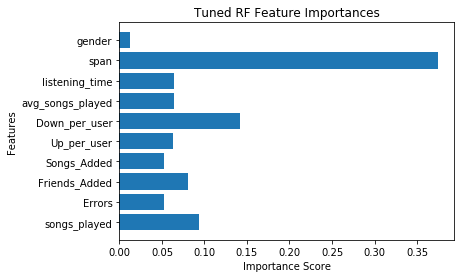

In [85]:
bestModel=rfmodel.bestModel
importances=bestModel.featureImportances

y_pos = np.arange(len(cols)) 
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Tuned RF Feature Importances');

So, from the visual above we can see that the most important features that play an important role in predicting customer churn are as follows:
#### 1)Span-The time for which a customer is using our application
#### 2)Down_per_user-Which meand the number of thumbs down done by the users
#### 3)Friends_added-The number of rriends added by the users
#### 4)Songs_played-The number of songs played by the users

# Conclusion

#### 1) We have successfully been able to predict the customer churn using pyspark with F-1 sore of 0.75.
#### 2)Different supervised classification methods such as Random Forest,Gradient Boosted Tree and Logistic regression were used to predict customer churn.Random Forest performed the best in predicting customer churn
#### 3)The most important features in predicting the customer churn are:the lifetime of the customer,the number of songs played by them,the number of thumbs down and the number of friends added.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.